# Introduction

This notebook shows the steps to prepate the maps needed for the wflow_* set of models. The wflow_prepare scripts have a number of specific features that are not used here. This notebook shows the principles and may be used as a template to create better preprocessing options.

In short the steps to generate input files for the wflow models are:

- Create a DEM for the catchment
- Create a local crainage network file for the catchment used the DEM and additional information
- Create a subarea/catchment map by indicating outflow points (gauges) in the map
- Convert/resample landuse and soil maps

The folloing maps are required:

- wflow_dem.map
- wflow_demmax.map (for sbm only)
- wflow_demmin.map (for sbm only)
- wflow_ldd.map
- wflow_landuse.map
- wflow_soil.map
- wflow_river.map
- wflow_subcatch.map

There are more maps but those are optional (but very useful). See the documentation of the wflow_prepare scripts for details

# Example

In [1]:
import os
#os.chdir("/mnt/c/Workspace/Ch3/wflow/")
#os.chdir("/mnt/d/Github/wflow/")
os.chdir(os.path.join("D:\\", "GitHub", "wflow"))

os.getcwd()

import wflow.wflow_lib as tr
import pcraster as pcr
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Process DEM to generate the ldd

Begin by importing the wflow_lib module. This module also imports the pcraster framework. Also set the names of the files we are going to use here.

In [2]:
ws_name = "san-diego_california_20331196_11023340"
#ws_name = "fulton_georgia_2047963_02336410"

#static_dir = str("/mnt/c/Workspace/Ch3/wflow_models/" + ws_name +  "/staticmaps_1km/")
static_dir = os.path.join("D:\\", "wflow_models", ws_name,  "staticmaps_1km")

#demfilename = "DEM_90m.map"
demfilename = "DEM.map"
#dem_dir = str(static_dir + demfilename)
dem_dir = os.path.join(static_dir, demfilename)
ws_dir = os.path.join(static_dir, "wflow_pre_ws.map")
print(dem_dir)

D:\wflow_models\san-diego_california_20331196_11023340\staticmaps_1km\DEM.map


start by reading the DEM into memory. Note that a DEM can be rather large, in that case it may be good to resample it first before reading it into memory.
Check the dem by plotting it. Note the use of the _pcr2numpy_ function to convert the pcraster map object to a numpy matrixCheck the dem by plotting it. Note the use of the _pcr2numpy_ function to convert the pcraster map object to a numpy matrix

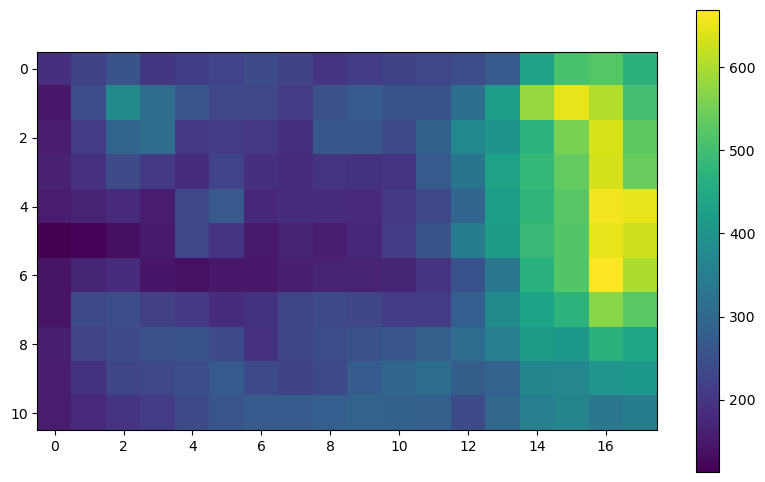

In [3]:
dem = pcr.readmap(dem_dir)
figure(figsize = (10,6))
imshow(pcr.pcr2numpy(dem,np.nan))
colorbar()

Determine the local drainage direction network from the DEM. This determines how the water flows from one cell to another. This may take some time

In [4]:
pcr.setglobaloption("lddout")

ldd = tr.lddcreate_save(str(static_dir + "/ldd.map"),dem,True)

We have now created a first version of the LDD. We can plot it with python but unfortunately it does not show the flow directions as nicely as the specialised pcraster graphics (aguila). We can however, use one of the pcraster functions (streamorder) to show how the main rivers run:

In [6]:
#!aguila "../wflow_models/bexar_texas_10836388_08181480/staticmaps/ldd.map" # This doesn't show anything really...

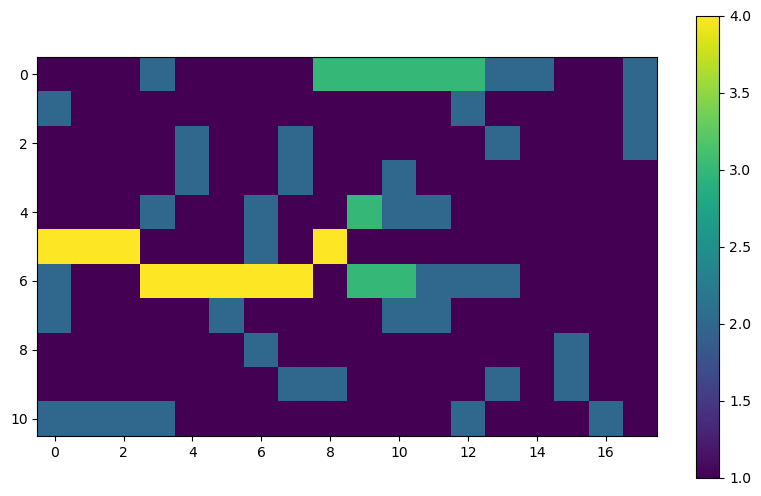

In [5]:
figure(figsize = (10,6))
strorder = pcr.streamorder(ldd)
imshow(pcr.pcr2numpy(strorder,np.nan))
colorbar()

wflow_lib has a function to search for the largest catchment within the current DEM. It returns a map with a single cell filled at the point of the outlet. Next we use that map to determine the whole catchment area:

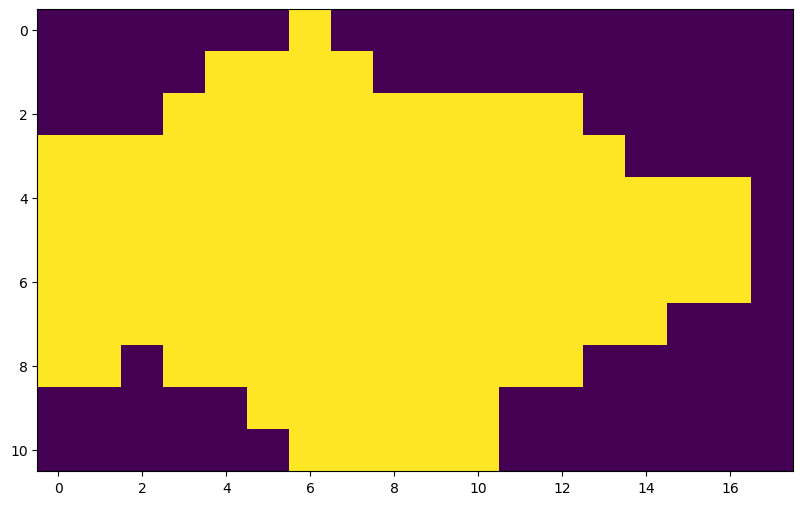

In [6]:
outletpoint = tr.find_outlet(ldd)
catch = tr.subcatch(ldd,outletpoint)
figure(figsize = (10,6))
imshow(pcr.pcr2numpy(catch,np.nan))

In this case we get something that is not  how we want it to be. In the northern and easter part of the map the catchment delineation seems to be missing stuff as we can be from the map below (which is more-or-less correct). The reason in this case is that a 1x1km DEM is missing some of the feature to correctly deliniate the DEM. One way to correct this is to use a know river course shapefile and use that to "burn in" the river into the DER and re-create the LDD.

### Use a river network to get better results

In this case we use a grid (converted from a shape-file, best to use qgis to do that) to burn-in the river network (only the higher orders). This will hopefully force the catchment deliniation process to follow the rigth track..

In [7]:
# Load flowline
river_dir = str(static_dir + "/flowline.map")
river = pcr.readmap(river_dir)

# I saved it in float64, and this may cause problem for calculation afterall. So converting it to int32 (pcr.ordinal)
river = pcr.ordinal(river)

# pcr.cover doesn't really work, so using ifthenelse to change "missing values" (which is expressed as -2,147,483,648 but somehow not automatically considred as missing) into 0
river = pcr.ifthenelse(pcr.ordinal(river) < 0, 0 , river)

# Convert PCRaster map to NumPy array
river_data = pcr.pcr2numpy(river, 0)

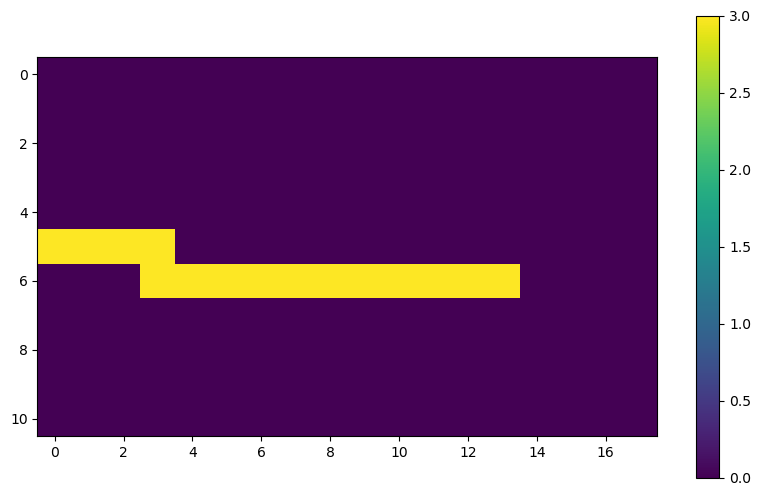

In [8]:
figure(figsize = (10,6))
imshow(river_data, vmin = np.nanmin(river_data), vmax=np.nanmax(river_data))
colorbar()

Now use this river network to adjust the DEM. This step (the averaging) takes some time....

In [9]:
pcr.setglobaloption("unitcell")
demregional = dem
#demregional=pcr.windowaverage(dem,90) # this one is not needed in my case..?
#ldddem = pcr.ifthenelse(pcr.scalar(river) >= 1.0, -9000 , demregional)
ldddem = pcr.ifthenelse(pcr.scalar(river) >= 1.0, demregional -9000 , dem)

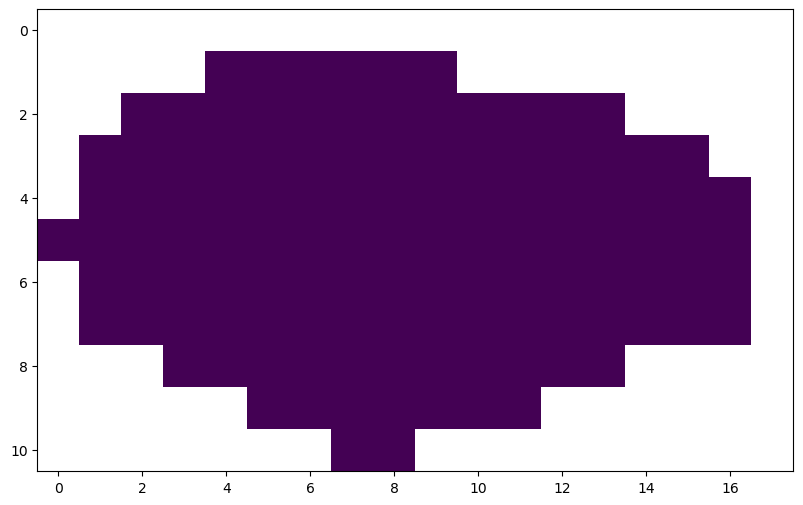

In [10]:
pre_ws = pcr.readmap(ws_dir)
pre_ws = pcr.scalar(pre_ws)
pre_ws = pcr.ifthenelse(pcr.scalar(pre_ws) < 0, 0 , pre_ws)
pre_ws_data = pcr.pcr2numpy(pre_ws, 0)

figure(figsize = (10,6))
imshow(pre_ws_data, vmin = np.nanmin(pre_ws_data), vmax=np.nanmax(pre_ws_data))

Recreate the LDD and see how it looks now...

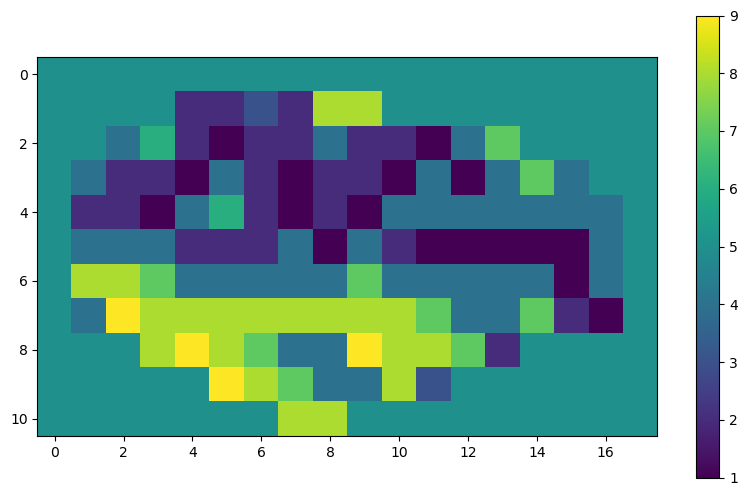

In [11]:
ldd = pcr.lddcreate(dem, 10.0e35, 10.0e35, 10.0e35, 10.0e35)
ldd = pcr.ifthenelse(pcr.scalar(pre_ws) >= 0.5, ldd, 5)

pcr.report(ldd, str(static_dir + "/wflow_ldd.map"))

strorder = pcr.streamorder(ldd)
figure(figsize = (10,6))
imshow(pcr.pcr2numpy(ldd,np.nan))
colorbar()

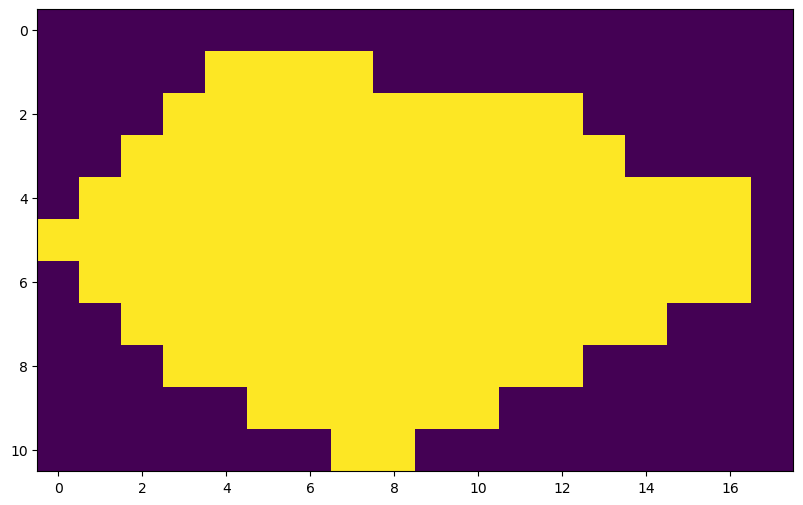

In [12]:
outletpoint = tr.find_outlet(ldd)
catch = tr.subcatch(ldd,outletpoint)
figure(figsize = (10,6))
imshow(pcr.pcr2numpy(catch,0))

### Now we read in the gauge location to get a couple of subcatchments

[       0 11023340]


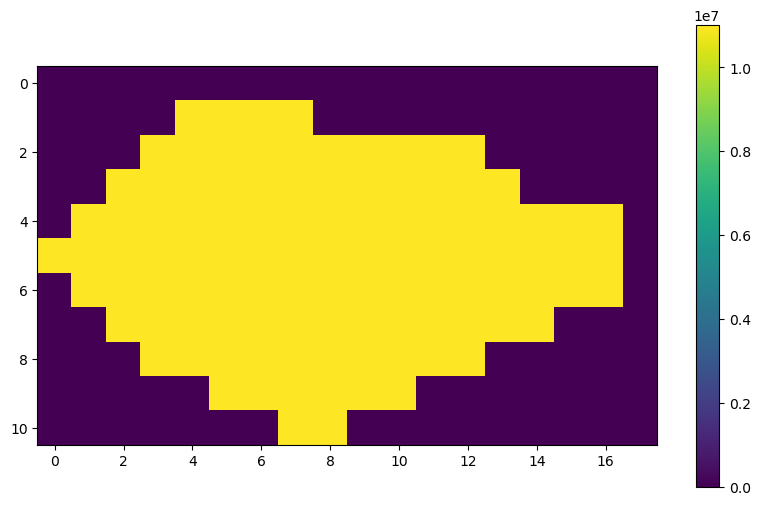

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

# Load available USGS gages in the WS.
gauges_dir = str(static_dir + "/gages.map")
gauges=pcr.readmap(gauges_dir)
gauges = pcr.ordinal(gauges)

# Do the same thing.
gauges = pcr.ifthenelse(pcr.ordinal(gauges) < 0, 0 , gauges)
#gauges_data = pcr.pcr2numpy(gauges,np.nan)

sc = tr.subcatch(ldd,gauges)
sc_data = pcr.pcr2numpy(sc,0)

# Define unique values in the data
unique_values = np.unique(sc_data)
print(unique_values)

unique_values2 = list(unique_values)
unique_values2.append(np.nanmax(unique_values) * 1.1)

# Setting color maps.
viridis_cmap = matplotlib.colormaps['viridis']
num_colors = len(unique_values2)  # Number of colors needed

# Extract specific colors from viridis based on the number needed
colors = viridis_cmap(np.linspace(0, 1, num_colors))
# Create a custom colormap using extracted colors
custom_cmap = LinearSegmentedColormap.from_list('custom_viridis', colors)
# Create a norm object using the unique values and custom colormap
norm = BoundaryNorm(unique_values2, custom_cmap.N)

#plt.imshow(sc_data, cmap=custom_cmap, norm=norm)
figure(figsize = (10,6))
plt.imshow(sc_data)
plt.colorbar()
plt.show()

Instead of defining subcatchments using gauges we can also use river junctions to find them. 

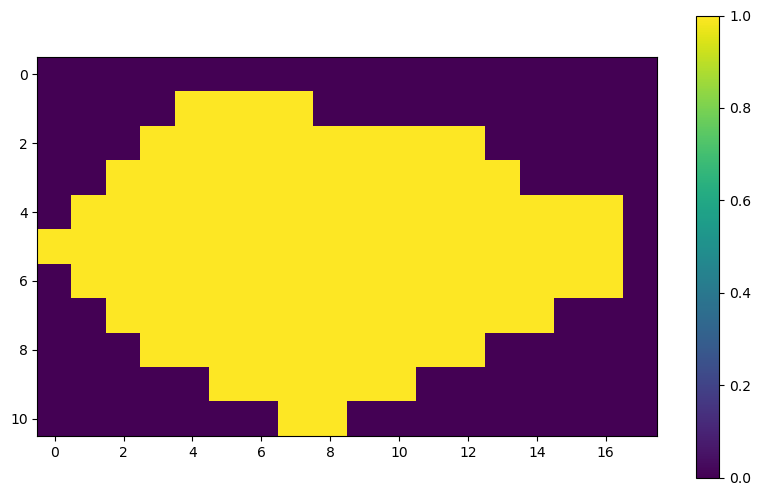

In [14]:
subcatch_from_order , virtgauges, b = tr.subcatch_order_a(ldd,8)
figure(figsize = (10,6))
imshow(pcr.pcr2numpy(subcatch_from_order,0.0))
plt.colorbar()

## OK, now use the subcatchments to mask the dem to the catchment we use and save the dem. This will speed-up later calculations. Also save the subcatchment and gauges

In [15]:
dem2 = pcr.ifthen(sc >0, dem) #using gauge defined subcatch
pcr.report(dem2,str(static_dir + "/wflow_dem.map"))
pcr.report(sc,str(static_dir + "/wflow_subcatch.map"))
# Also save the gauged
pcr.report(pcr.ifthen(gauges>0,gauges),str(static_dir + "/wflow_gauges.map"))

Make a wflow_river file by including only rivers with stralerorder of 6 and larger

In [16]:
strorder = pcr.streamorder(ldd)
strorder_data = pcr.pcr2numpy(strorder, np.nan)
vmin= np.nanmin(strorder_data)
vmax= np.nanmax(strorder_data)
vmean= np.mean(strorder_data)
vmed= np.median(strorder_data)

thresh = np.percentile(strorder_data, 97.5)

print(thresh)
#vmax

pcr.report(pcr.ifthen(strorder>= int(thresh),strorder),str(static_dir + "/wflow_river.map"))

4.0


# landuse, soil, sufraceArea, velocity

In [17]:
print(static_dir)

D:\wflow_models\san-diego_california_20331196_11023340\staticmaps_1km


In [18]:
pcr.setclone(static_dir + "/wflow_dem.map")
ws = 0.0 * pcr.scalar(sc) + 1.0
pcr.report(pcr.nominal(ws), static_dir + "/wflow_ws.map")
pcr.report(pcr.nominal(1), static_dir + "/wflow_soil.map")
pcr.report(pcr.nominal(1), static_dir + "/wflow_landuse.map")
pcr.report(pcr.nominal(1), static_dir + "/wflow_transit.map")

pcr.setglobaloption("unittrue")
pcr.report(pcr.cellarea(), static_dir + "/wflow_surfaceArea.map")

In [19]:
wflow_velocity = pcr.ifthen(dem2 > (-100), pcr.scalar(3600))
pcr.report(wflow_velocity, static_dir + "/wflow_velocity.map")